# Inflation Forecast and Interest Rate Data

This program downloads, manages, and exports to .csv files inflation forecast data from the Federal Reserve Bank of Philadelphia, and actual inflation and interest rate data from FRED. The purpose is to learn about the differences between actual and expected inflation and to learn about historical *ex ante* real interest rates in the US.

In [1]:
import numpy as np
import pandas as pd
import fredpy as fp
import requests
import os
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

## Download forecast data from SPF

https://www.philadelphiafed.org/surveys-and-data/real-time-data-research/inflation-forecasts

In [2]:
url = 'https://www.philadelphiafed.org/-/media/frbp/assets/surveys-and-data/survey-of-professional-forecasters/historical-data/inflation.xlsx?la=en&hash=F9C3E76769B4586C3E36E403DFA54BDC'

r = requests.get(url,verify=True)
with open("../xlsx/inflation.xlsx", "wb") as code:
    code.write(r.content)

## Manage forecast data

In [3]:
# Load data from Excel file
inflation_forecasts = pd.read_excel('../xlsx/inflation.xlsx',sheet_name='INFLATION')

# Construct DatatimeIndex
inflation_forecasts.index = pd.DatetimeIndex(inflation_forecasts['YEAR'].astype(int).astype(str)+'-Q'+inflation_forecasts['QUARTER'].astype(int).astype(str),freq='QS')

# Shift dates forward one year
inflation_forecasts.index = inflation_forecasts.index.shift(4)

# Drop unnecessary columns
inflation_forecasts = inflation_forecasts.drop(['YEAR','QUARTER','INFCPI10YR'],axis=1)

# Fill missing value for July 1974
inflation_forecasts = inflation_forecasts.interpolate(limit_area='inside')

# Rename remaining columns
inflation_forecasts.columns = ['DEFLATOR','CPI']

/Users/bcjenkin/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


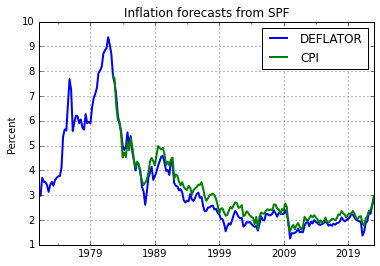

In [4]:
fig,ax = plt.subplots()
inflation_forecasts.plot(ax=ax,lw=2,grid=True)
ax.set_title('Inflation forecasts from SPF')
ax.set_ylabel('Percent');

## Download and manage data from FRED

* GDP deflator, quarterly (GDPDEF)
* CPI, monthly ()
* Yield on U.S. Treasury Securities at 1-Year Constant Maturity, monthly (GS1)

In [5]:
# Download GDP deflator data
deflator = fp.series('GDPDEF').data

# Construct inflation rate over previous 4 quarters
deflator = 100*(deflator/deflator.shift(4)-1)

In [6]:
# Download CPI data
cpi = fp.series('CPIAUCSL').data

# Construct inflation rate over previous 12 months
cpi = 100*(cpi/cpi.shift(12)-1)

# Take only CPI values for first month of quarter
cpi = cpi.asfreq('QS')

In [7]:
# Download 1 year T-bill rate
nominal_rate = fp.series('GS1').data

# Convert to quarterly frequency 
nominal_rate = nominal_rate.asfreq('QS')

## Prepare dataset and export

In [8]:
df = pd.concat([inflation_forecasts,deflator,cpi,nominal_rate],axis=1)
df = df[df['DEFLATOR'].notna()]

df.columns = [
    'deflator inflation - forecast',
    'cpi inflation - forecast',
    'deflator inflation - actual',
    'cpi inflation - actual',
    'nominal interest'
]

df.to_csv('../csv/inflation_forecast_data.csv')

## Plots

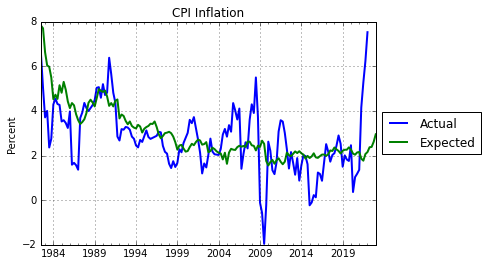

In [9]:
# Actual and forecasted CPI inflation
fig,ax = plt.subplots()
cpi = df[df['cpi inflation - forecast'].notna()][['cpi inflation - actual','cpi inflation - forecast']]
cpi.plot(legend=False,ax=ax,lw=2)

ax.legend(['Actual','Expected'],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('CPI Inflation')
ax.set_ylabel('Percent')
ax.grid()

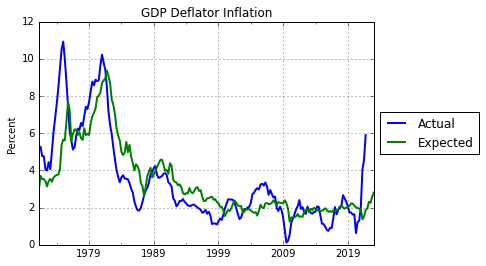

In [10]:
# Actual and forecasted GDP deflator inflation
fig,ax = plt.subplots()
deflator = df[df['deflator inflation - forecast'].notna()][['deflator inflation - actual','deflator inflation - forecast']]
deflator.plot(legend=False,ax=ax,lw=2)

ax.legend(['Actual','Expected'],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('GDP Deflator Inflation')
ax.set_ylabel('Percent')
ax.grid()

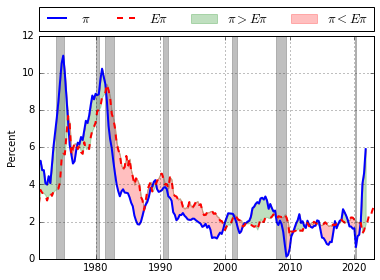

In [11]:
# Figure for website
fig,ax = plt.subplots()
ax.plot(deflator['deflator inflation - actual'],'-b',lw=2,label='$\\pi$')
ax.plot(deflator['deflator inflation - forecast'],'--r',lw=2,label='$E\\pi$')
ax.fill_between(deflator.index,deflator['deflator inflation - forecast'],np.max([deflator['deflator inflation - actual'],deflator['deflator inflation - forecast']],axis=0),color='g',alpha=0.25,label='$\\pi>E\\pi$')
ax.fill_between(deflator.index,np.max([deflator['deflator inflation - actual'],deflator['deflator inflation - forecast']],axis=0),deflator['deflator inflation - actual'],color='r',alpha=0.25,label='$\\pi<E\\pi$')
fp.recessions(start=deflator.index[0],end=deflator.index[-1])
ax.grid()
ax.set_ylabel('Percent')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4,borderaxespad=0., mode="expand",fontsize=13)


plt.savefig('../png/fig_US_Inflation_Forecast_site.png',bbox_inches='tight')

## Delete SPF data files

In [12]:
os.remove('../xlsx/inflation.xlsx')